# Emukit - Bayesian Optimization with Non-Linear Constraints

This notebook demonstrates the use of emukit to perform Bayesian optimization with non-linear constraints. 

In Bayesian optimization we optimize an acquisition function to find the next point to evaluate the objective function:

$$
\mathbf{x}^* = \arg \min A(\mathbf{x})
$$

We now want to add some non-linear constraints to ensure that $g(\mathbf{x}^*) > 0$. To do this we multiply the acquisition function with a penalization function that is approximately 1 if the constraint is satisfied and approximately zero otherwise:

$$
\mathbf{x}^* = \arg \min A(\mathbf{x}) \,\sigma\left(g\left(\mathbf{x}\right)\right)
$$

where $\sigma(\cdot)$ is the sigmoid function. To construct this augmented acquisition function in emukit, we take advantage of emukit's ability to multiply different acquisition functions.

Note that this method only works with positive acquisition functions and does not guarantee that the constraint will be satisfied. If you find the constraint is violated often, you can apply a multiplicative factor to $g(\mathbf{x})$ that will make the increase the penalization of the acquisition function when the constraint is violated.

In [ ]:
FIG_SIZE = (12, 8)

# Objective

We will aim to optimize the 2D-Branin function.

In [ ]:
from emukit.test_functions import branin_function
fcn, space = branin_function()

# Constraint function

Define constraints as a circle of raidus 4 centred at (3, 7).

In [ ]:
constraint_radius = 4
constraint_fcn = lambda x: 10 * (-(x[:, 0] - 3)**2 - (x[:, 1] - 7)**2 + constraint_radius ** 2)[:, None]

optimum = np.array([[-np.pi, 12.275], [np.pi, 2.275], [9.42478, 2.475]])

# Plot objective with constraints

Constraint boundary is show in black, inside the circle the constraint is satisfied and outside it is violated. The red crosses show the location of the unconstrained optima.

In [1]:
import numpy as np
# evaluate objective on grid to plot
x_1 = np.linspace(-5, 10, 50)
x_2 = np.linspace(0, 15, 51)
x_1_grid, x_2_grid = np.meshgrid(x_1, x_2)
x_all = np.stack([x_1_grid.flatten(), x_2_grid.flatten()], axis=1)
y_all = fcn(x_all)
y_reshape = np.reshape(y_all, x_1_grid.shape)

# evaluate constraint to plot
theta_constraint = np.linspace(0, 2*np.pi)
x_0_constraint = 3 + np.sin(theta_constraint) * constraint_radius
x_1_constraint = 7 + np.cos(theta_constraint) * constraint_radius

import matplotlib.pyplot as plt
plt.figure(figsize=FIG_SIZE)
plt.contourf(x_1, x_2, y_reshape)
plt.title('Branin Function')
plt.plot(x_0_constraint, x_1_constraint, linewidth=3, color='k')
plt.plot(optimum[:, 0], optimum[:, 1], marker='x', color='r', linestyle='')
plt.legend(['Constraint boundary', 'Unconstrained optima']);

# Gaussian process model

In [2]:
import GPy
from emukit.model_wrappers import GPyModelWrapper

x_init = np.array([[0, 7], [1, 9], [6, 8]])
y_init = fcn(x_init)

model = GPy.models.GPRegression(x_init, y_init)
emukit_model = GPyModelWrapper(model)

# Define ConstraintAcquisition class

This class represents the $\sigma\left(g\left(\mathbf{x}\right)\right)$ part of the acqiusition.

In [3]:
from emukit.core.acquisition import Acquisition
from scipy.special import expit # expit is scipy's sigmoid function
class ConstraintAcquisition(Acquisition):
    def __init__(self, constraint_fcn):
        self.constraint_fcn = constraint_fcn
        
    def evaluate(self, x):
        return expit(self.constraint_fcn(x))
    
    @property
    def has_gradients(self):
        return False

In [4]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
ei = ExpectedImprovement(model)
augmented_acquisition = ei * ConstraintAcquisition(constraint_fcn)

In [5]:
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

# Plot function

This function will be called at the end of each iteration so we can see the progress of the optimization

In [6]:
def plot_progress(loop, loop_state):
    plt.figure(figsize=FIG_SIZE)
    plt.contourf(x_1, x_2, y_reshape)
    plt.plot(x_0_constraint, x_1_constraint, linewidth=3, color='k')
    plt.plot(loop_state.X[:-1, 0], loop_state.X[:-1, 1], linestyle='', marker='.', markersize=16, color='b')
    plt.plot(loop_state.X[-1, 0], loop_state.X[-1, 1], linestyle='', marker='.', markersize=16, color='r')
    plt.legend(['Constraint boundary', 'Previously evaluated points', 'Last evaluation'])

# Run optimization loop

Optimization restart 1/1, f = 14.84099333854313
Optimization restart 1/1, f = 19.20584994136985
Optimization restart 1/1, f = 23.402258362843025
Optimization restart 1/1, f = 27.47474305090889
Optimization restart 1/1, f = 31.44672389496067
Optimization restart 1/1, f = 34.4357180701877
Optimization restart 1/1, f = 0.7240386330126434
Optimization restart 1/1, f = 4.246094704614007
Optimization restart 1/1, f = 9.957013553622037
Optimization restart 1/1, f = 11.299002416597848
Optimization restart 1/1, f = 14.342010123689306


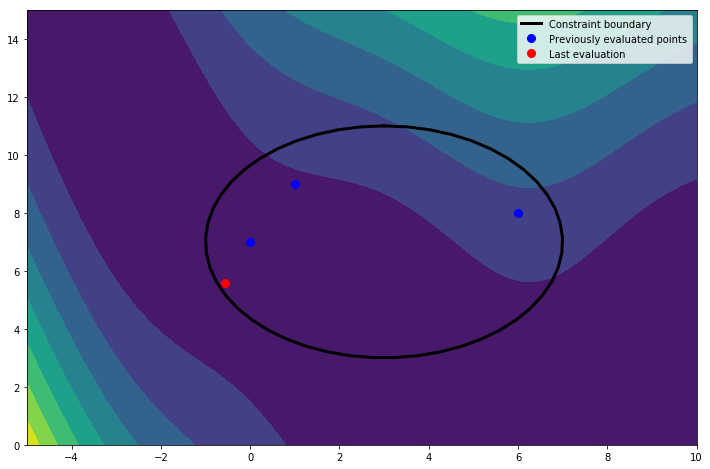

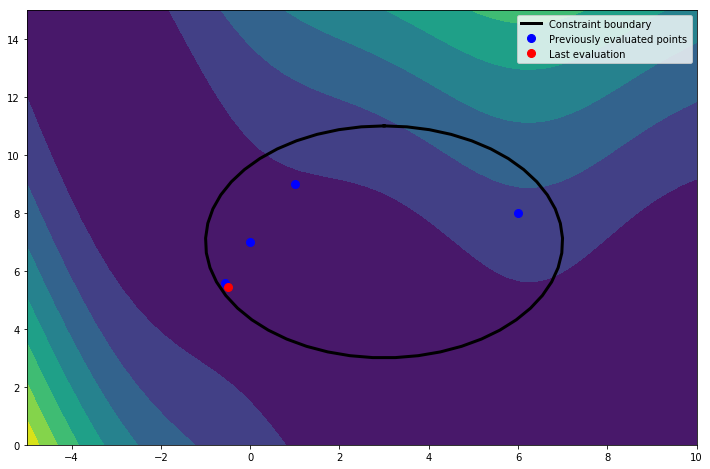

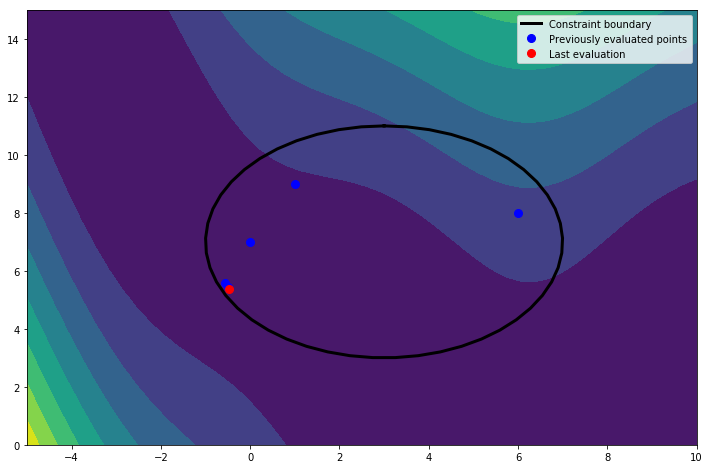

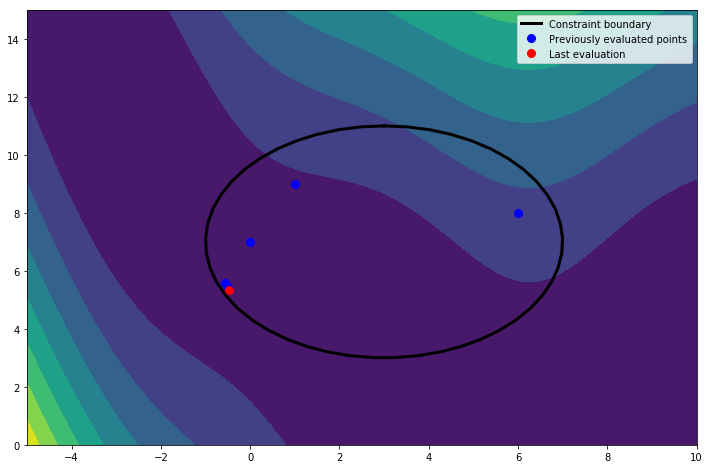

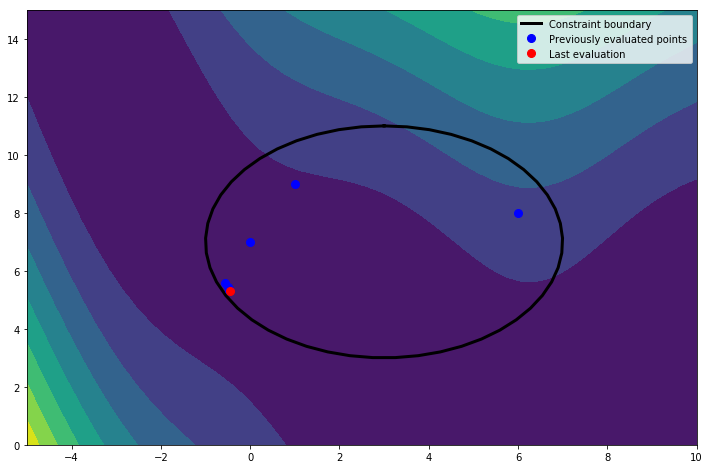

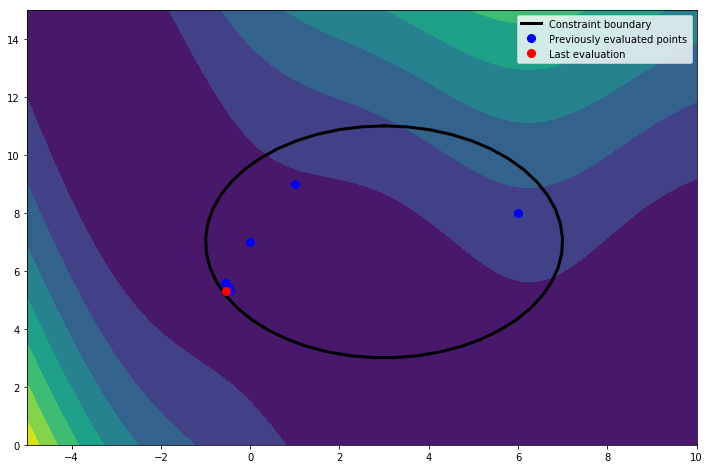

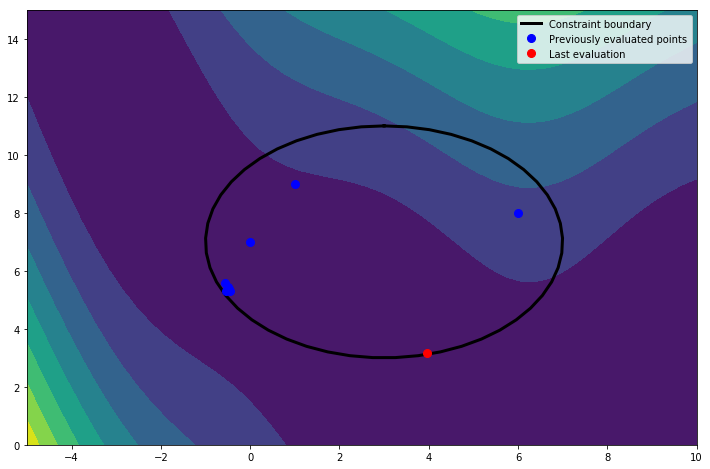

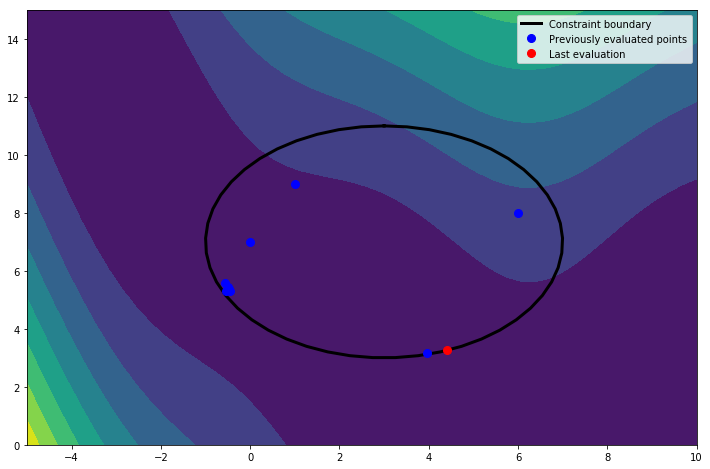

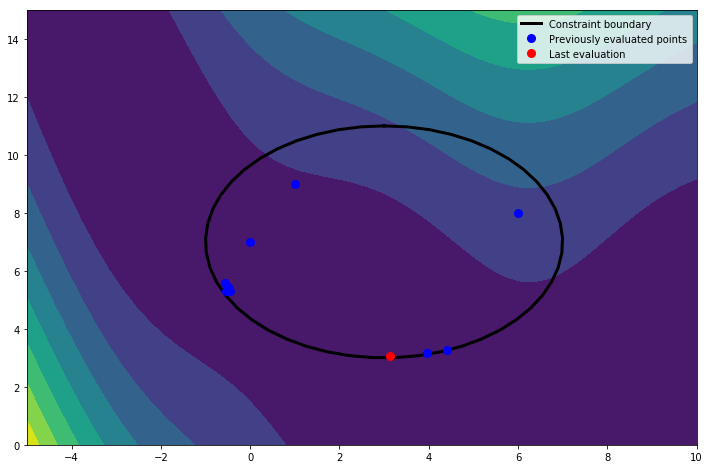

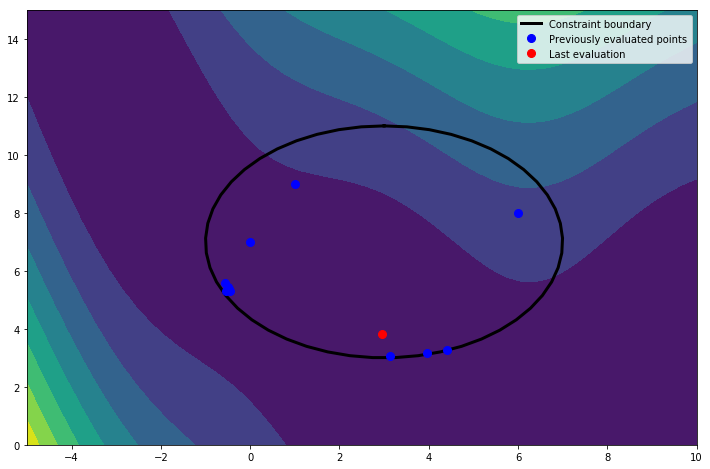

In [7]:
bo_loop = BayesianOptimizationLoop(space, emukit_model, augmented_acquisition)
# append plot_progress function to iteration end event
bo_loop.iteration_end_event.append(plot_progress)
bo_loop.run_loop(fcn, 10)

We can see that all the points emukit chose to evaluate were inside the constraint!